<a href="https://colab.research.google.com/github/pr31988/PyTorch-Fundamentals/blob/main/_PyTorch_WorkFlow_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Workflow covered:
  1. data: (prepare & load)
  2. Build a Model
  3. Fitting model to data (training)
  4. Making predictions & evaluating the model (Inference)
  5. saving & loading the Model
  6. Putting it all together

In [1]:
import torch
from torch import nn # nn contains all building blocks of pyTorch neural Networks
import matplotlib.pyplot as plt

# check torch version
torch.__version__

'2.5.1+cu121'

Machine Learning mainly Game of two parts:
1. Turn Data into numbers
2. build a model to learn patterns in those numbers

# first example with **Linear regression** to train a model & draw pattern

In [2]:
# y = a + b * X --> b is slope of line

## create parameters
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias
X[:10] , y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [3]:
len(X), len(y)

(50, 50)

Splitting data into Training & Test sets(one of the most important concept in machine learning)

In [4]:
# create train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]

X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
def plot_prediction(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None):
  """
  plots training data, test data & compares prediction
  """

  #plot training data in red
  plt.scatter(train_data,train_labels, s=4, c="r", label="Training data")

  #plot test data in green
  plt.scatter(test_data, test_labels, s=4, c="g", label="Test data")

  if predictions is not None:
    # plot the predictions if any
    plt.scatter(test_data, predictions, s=6, c="b", label="predictions")

  # show the legend
  plt.legend(prop={"size": 15})


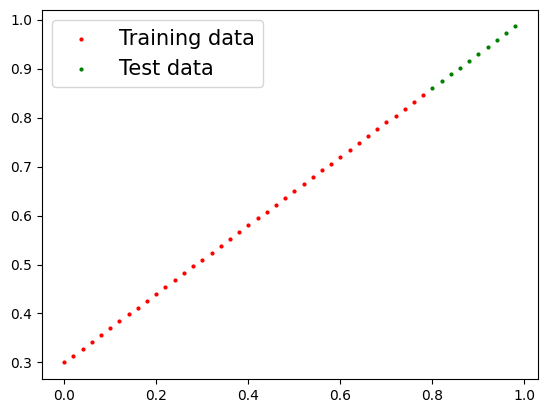

In [6]:
plot_prediction();

create a Model using training data, Model will determine weight & bias values

what our Model does:
1. start with random values (wight & bias)
2. Look at training data and adjust these random values(or get closer to) ideal values (the actual weight & bias we used to create training & test data)

to do so it uses 2 main algorithms:
1. Gradient descent   - https://www.youtube.com/watch?v=IHZwWFHWa-w
2. Backpropagation - https://www.youtube.com/watch?v=Ilg3gGewQ5U

In [7]:
from torch import nn

# create a linear Regression Model class
class LinearRegressionModel(nn.Module):  # <-- almost everything in pyTorch is inheritted from nn.Module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,      # --> start with a random weight and try to adjust it to ideal weight
                                            requires_grad=True,
                                            dtype=torch.float32))

    self.bias = nn.Parameter(torch.randn(1,         # --> start with a random bias and try to adjust it to ideal bias
                                        requires_grad=True,
                                        dtype=torch.float32))

  # forward method to define the computation in the module
  def forward(self, x: torch.Tensor) -> torch.Tensor:   # <-- "x" is the input data
      return self.weights * x + self.bias # linear regression formula

  PyTorch essentials:
  * torch.nn   -   provides all building blocks [its a tool set]
  * torch.nn.Parameter - const values our Model should learn & predict
  * torch.nn.Module  - base class
  * torch.optim - optimize parameters to get actuals
  * def forward - takes data from nn.Module and defines what happens in {forward} computation

In [8]:
torch.manual_seed(42)

model_0 = LinearRegressionModel()  # --> create a random instance of the class (this is subclass on nn.Module)

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# list named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

# Making prediction with torch.inference_mode()
to check our Models prediction power lets see how it predicts y_test based on x_test

 --> when we pass data to the Model its going to run it through forward method


In [10]:
# before using prediction power of our Model
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

In [11]:
# with inference method, model is solely predicting values and not training the model. It is not keeping track of the things but just deriving the infenrence
# long story short ***Code runs faster***
# the older version is torch.no_grad()

with torch.inference_mode():
# with torch.no_grad():
  y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

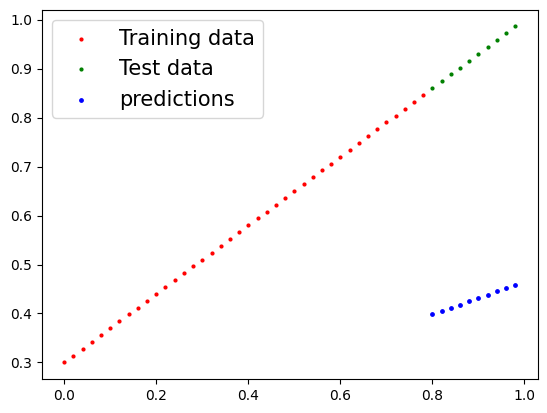

In [12]:
plot_prediction(predictions=y_preds)

Train Model:

The whole idea of training the model, is moving from poorly predicted parameter values towards ideal parameter values

if we can meansure how poor the prediction is, it will be posible to adjust parameters to actual values

One way is to use Loss Function

Things we need to train:
*  **Loss Function**: The function to measure how wrong the model predictions are compared to the ideal output
*  **Optimizer** : Takes in account the loss of the model and adjust parameters to lower the loss.

for PyTorch we need:
*   **Training Loop**
*   **Testing Loop**

In [13]:
# loss function
loss_fn = nn.L1Loss()

# optimizer SGD (Scholistic Gradient Descent)
optim_fn = torch.optim.SGD(params=model_0.parameters(),
                           lr=0.01) # learning rate --> its a hyperparameter set manually, rate at which the loss

Building **training loop** (testing loop) in PyTorch :

we need:

0. Loop thorugh data
1. Forward pass (involves data passing through our model's foraward () function) to make prediction on data - also called forward propagation
2. calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimzer zero grad
4. Loss backward - move backwards throght the network to calculate gradients for each of the parameters of our model with respect to the loss (**back propagation**)
5. Optimizer step - use the optimizer to adjust the parameters to try and lower the loss (**Gradient Descent**)

In [30]:
torch.manual_seed(42)

epochs = 110  # its a hyper parameter

### Training
# 0. loop through data
for epoch in range(epochs):

# set the model to training mode
  model_0.train()

# 1. forward Pass
  y_preds = model_0(X_train)

#2. calculate the loss function
  loss = loss_fn(y_preds, y_train)

# 3. optimizer zero grad
  optim_fn.zero_grad()

# 4. perform backward propagation on the loss with respect to the parameters in the model (calculate gradients of each parameter)
  loss.backward()

#5. optimizer step (perform gradient descent)
  optim_fn.step() # step the optimizer, to update the model's parameters with respect to the gradients calculated by step(4)
#
model_0.state_dict()

OrderedDict([('weights', tensor([0.6951])), ('bias', tensor([0.2993]))])

In [31]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

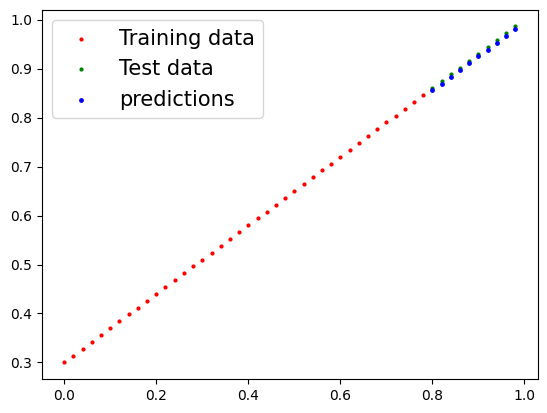

In [33]:
plot_prediction(predictions=y_preds_new)